# Deep Evidential Regression
Deep Evidential Regression (DER) is a technique that trains a single deterministic network to learn four outputs which characterize evidential priors over the original Gaussian likelihood function. We learn the parameters of a joint conjugate prior (Normal-Inverse-Gamma) that hierarchically parameterizes the Gaussian likelihood.

Following - https://arxiv.org/abs/1910.02600

With a modified loss function and calculation of aleatoric and epistemic uncertainty from - https://arxiv.org/abs/2205.10060 

The loss function modification and DER and SDER models are taken from - https://github.com/pasteurlabs/unreasonable_effective_der/tree/main

In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from scripts import train, models, analysis, io

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [5]:
DER_TYPE = 'DER'  # 'sDER'
noise = 'low'
# model_name will be used to save the model by checkpoint
model_name = DER_TYPE + '_noise_' + noise
norm = 'False' # if you normalize, rn the normalized version doesn't work
n_epochs = 100
BATCH_SIZE = 100

In [6]:
if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
    DERLayer = models.DERLayer
    loss_der = models.loss_der
if DER_TYPE == 'SDER':
    #The below were the numbers for SDER originally
    #LR = .005    # learning rate
    #COEFF = 2.   # lambda
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Load linear data from h5
There are multiple noise options, so define sigma first.

In [7]:
if noise == 'low':
    sigma = 1
if noise == 'medium':
    sigma = 5
if noise == 'high':
    sigma = 10
size_df = 1000

In [8]:
loader = io.DataLoader()

In [9]:
data = loader.load_data_h5('linear_sigma_'+str(sigma)+'_size_'+str(size_df))

In [10]:
len_df = len(data['params'][:,0].numpy())
len_x = len(data['inputs'].numpy())
ms_array = np.repeat(data['params'][:,0].numpy(), len_x)
bs_array = np.repeat(data['params'][:,1].numpy(), len_x)
xs_array = np.tile(data['inputs'].numpy(), len_df)
ys_array = np.reshape(data['output'].numpy(), (len_df * len_x))

print('shapes',
      np.shape(ms_array),
      np.shape(bs_array),
      np.shape(xs_array),
      np.shape(ys_array))

shapes (101000,) (101000,) (101000,) (101000,)


<Figure size 640x480 with 0 Axes>

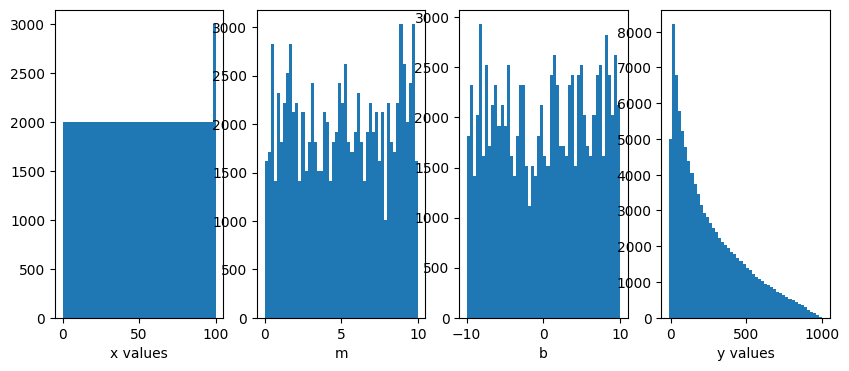

In [11]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [12]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [13]:
if norm == 'True':
    print('normalized version', norm)
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    print('not normalizing')
    model_inputs = inputs
    model_outputs = ys_array

not normalizing


<Figure size 640x480 with 0 Axes>

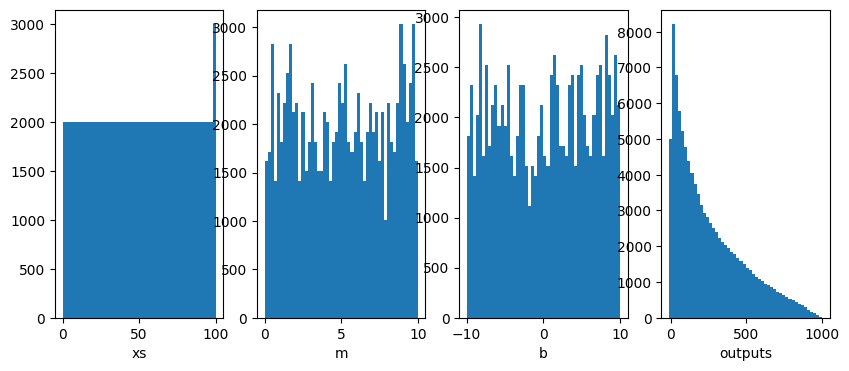

In [14]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


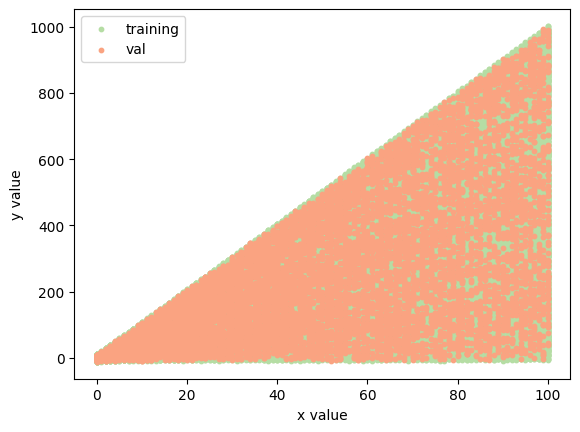

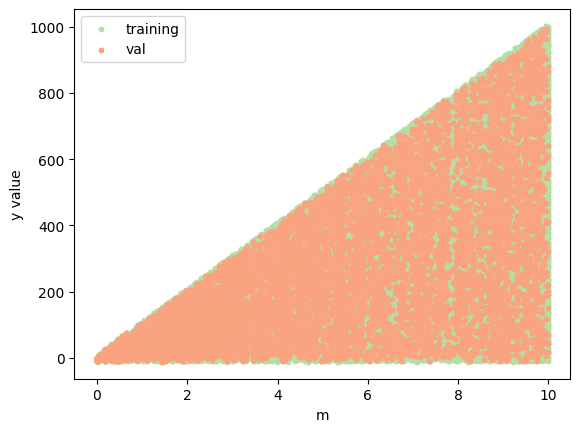

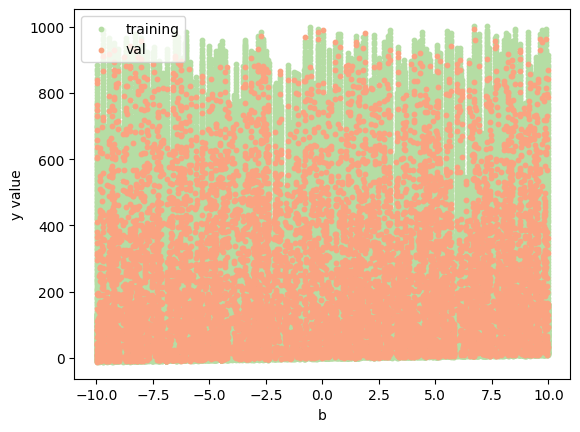

In [15]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [16]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


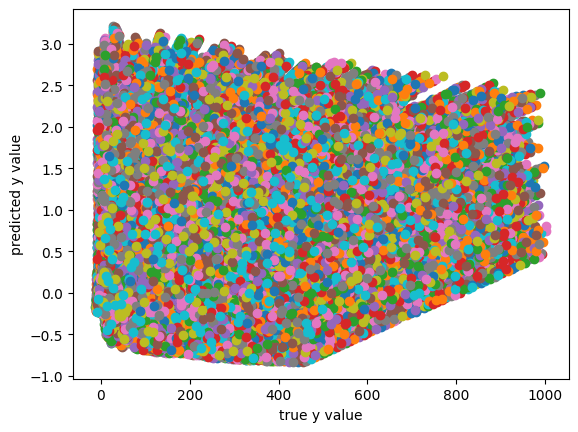

In [17]:
# plot what we're trying to predict
counter = 0
model, loss = models.model_setup_DER(DER_TYPE, DEVICE)
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(DEVICE), y.to(DEVICE))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()

    
    plt.scatter(y, pred[:,0], linestyle='None')
    
    counter += 1
plt.xlabel('true y value')
plt.ylabel('predicted y value')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()

[INFO] training the network...
saving checkpoints?
False
saving here: ../models/
model name: DER_noise_low
epoch 0 0.0
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[1.0426081  1.779848   0.5156829  1.0036777  0.34304374 0.63782537
 1.6371267  0.55157363 1.6144581  1.7626823  1.6259248  0.9945019
 1.0507162  1.3573353  1.8690823  2.0138142  1.603816   1.3222017
 1.4425207  0.66190356 1.8082172  1.9564917  0.5823237  1.7165928
 0.8043015  1.131583   0.9421069  1.0248424  0.9639702  0.97677004
 0.821413   0.4500594  0.8409272  0.70264596 1.223035   1.0547336
 0.9129754  1.2316937  0.8794056  1.8663465  1.8088562  1.3318632
 1.2092775  1.9448596  1.0500418  1.3342674  0.29771066 1.0272083
 0.6753457  1.4420321  1.4262041  0.54655015 1.525523   1.4222476
 1.1642354  1.0448338  1.4940166  1.5885786  1.4483868  1.7798477
 1.1778233  0.8131842  1.1424714  0.18918231 0.57537097 1.1343707
 0.8862708  0.41639757 1.6026653  0.815396   1.2767587  0.46382898
 0.44850415

<Figure size 640x480 with 0 Axes>

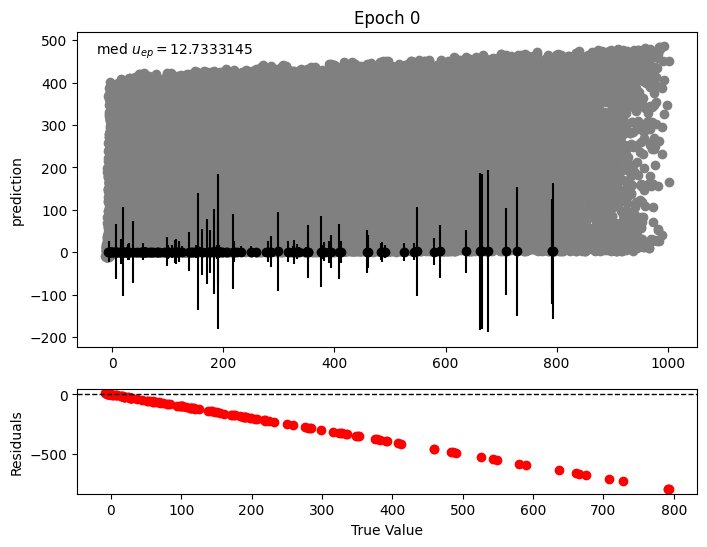

new best loss 7.050353527069092 in epoch 0
epoch 1 0.01
new best loss 5.257919788360596 in epoch 1
epoch 2 0.02
new best loss 4.539200305938721 in epoch 2
epoch 3 0.03
new best loss 4.338525772094727 in epoch 3
epoch 4 0.04
new best loss 4.078017711639404 in epoch 4
epoch 5 0.05
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[258.9599     73.95365   204.59969   548.2402    259.09073   223.32562
 609.9426    221.6387    233.19675    82.1113    275.994     445.33102
  94.402176  142.32442   199.10121   515.8227     12.861406  654.949
  17.35285   671.57526   275.48483   777.9056     38.844448  239.46786
 102.4559     86.68558   150.73045   433.6377     26.185911  721.9879
  17.633175  122.61529   162.97554   141.67235    14.852725  390.1098
 452.91193    62.396725   46.158993   80.08666    92.8346    112.61458
   7.821258  130.41304    12.27917   102.19703   388.97144    86.984825
   4.162155   -1.739133   55.640575  125.89803   501.62183    -5.3999934
 793.17

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

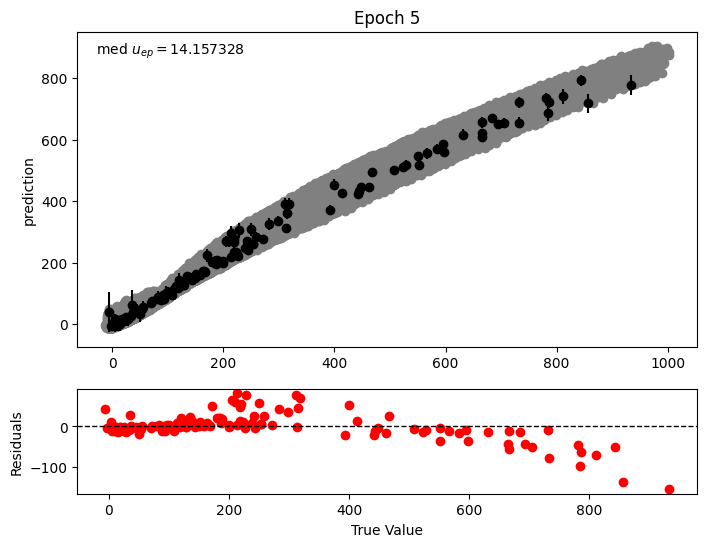

new best loss 3.987185478210449 in epoch 5
epoch 6 0.06
new best loss 3.7873287200927734 in epoch 6
epoch 7 0.07
new best loss 3.6162991523742676 in epoch 7
epoch 8 0.08
new best loss 3.3662123680114746 in epoch 8
epoch 9 0.09
epoch 10 0.1
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[630.4672     18.223618  343.38376   757.15607    29.899918   40.003212
 108.695175  379.6241    578.4192    450.40878    72.95914   348.41272
  21.78991   245.03957   304.25153   234.02208   224.00282   557.3757
 183.76793   268.87402   525.8137    154.18091   105.64167    29.400114
 206.08159   127.766685  275.4051     12.897358  122.07487   868.9149
 300.1497    377.32925    55.331028  222.02943   526.5261    106.677536
  -6.4141517 450.88562   337.16565    54.926     384.4482    348.62222
  43.139786   17.25936    25.527288  376.6755    234.4572     77.13623
  21.887817   51.02063   264.58295   926.7584     40.924034  497.23337
 603.5215    359.32248   706.1131    566.0914

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

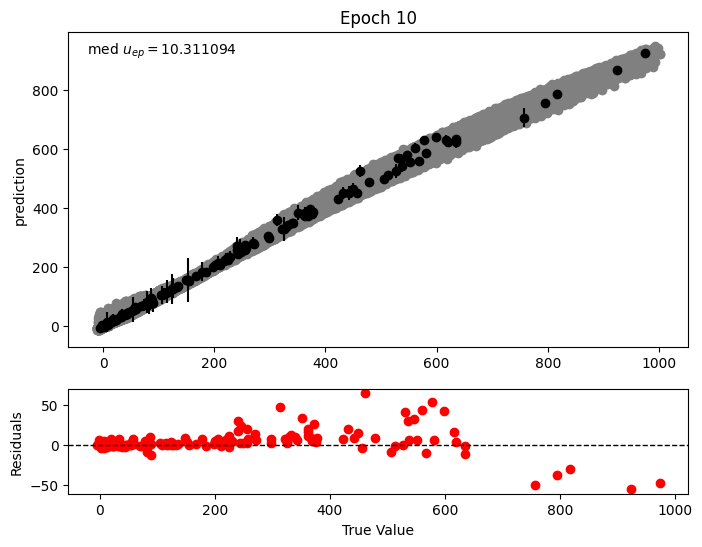

new best loss 3.0482747554779053 in epoch 10
epoch 11 0.11
new best loss 2.9329514503479004 in epoch 11
epoch 12 0.12
new best loss 2.797231435775757 in epoch 12
epoch 13 0.13
new best loss 2.7192113399505615 in epoch 13
epoch 14 0.14
new best loss 2.6913347244262695 in epoch 14
epoch 15 0.15
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 1.79430862e+02  8.72803497e+00  2.10350693e+02  2.63021881e+02
  1.82578140e+02  2.66054535e+02  5.86546509e+02  4.25385529e+02
  1.46358862e+01  7.32677856e+02  5.79708740e+02  7.20413391e+02
  3.96951965e+02  3.92266159e+01  1.51521969e+01  2.64489960e+02
  5.18695831e+01  2.97134796e+02  6.81585022e+02  1.45834360e+01
  1.79059555e+02  3.23068817e+02  4.37466248e+02  3.66542114e+02
  1.27655365e+02  8.69809723e+00  1.04998726e+02  2.64843781e+02
  3.52000244e+02  6.90305908e+02  9.57099762e+01  1.97447830e+02
  6.57624054e+01  3.31664276e+02  2.49892693e+01  1.38052826e+02
  2.01733337e+02  2.00541138e+02  5.77095795e+

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

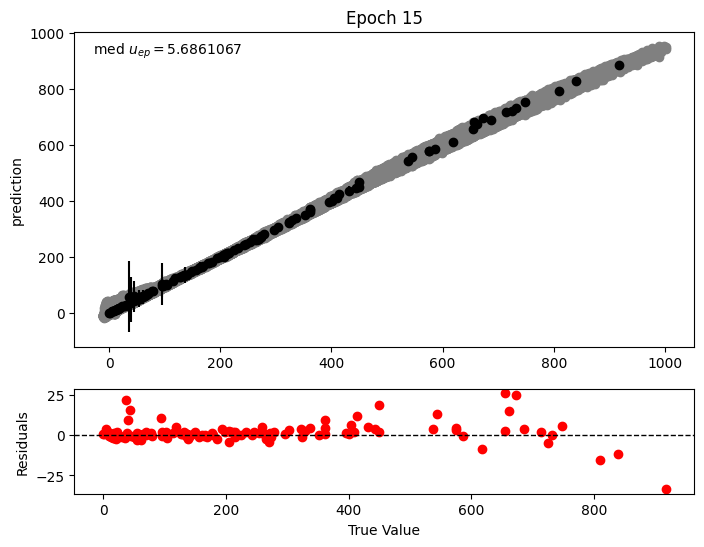

epoch 16 0.16
epoch 17 0.17
new best loss 2.4362716674804688 in epoch 17
epoch 18 0.18
epoch 19 0.19
epoch 20 0.2
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[242.05507    -6.585606  350.392     441.94882   334.60388    83.78887
  17.133179  742.3479     29.396423  161.9818    353.22885   387.93292
 122.18432   905.0224    385.40887   102.02779   592.27405   133.07336
  94.51443    93.36803   219.40932    -3.3908331 477.23962   650.49493
 855.4458    265.05182   247.52763    69.83637   177.18332   753.3204
 848.43884   394.67212    31.357662  613.28375   248.8775     34.362774
 506.22253   288.25314   210.08052   902.419      75.99168   651.44745
 546.1652    767.37537    71.07123    27.31264     4.8163414 112.119064
  45.454624   24.90566   905.22565   462.9555     16.046938  214.60309
 190.18463   481.42252   548.3259    604.05994    98.47419    37.52711
 491.38647   514.5686    130.94443   325.7005    298.94022   588.5328
  92.166725  876.20667   561.3

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

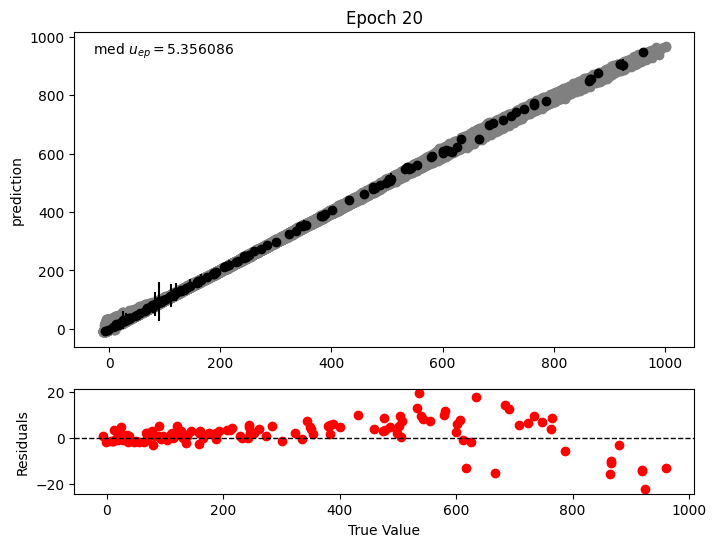

new best loss 2.3130810260772705 in epoch 20
epoch 21 0.21
epoch 22 0.22
epoch 23 0.23
new best loss 2.2826318740844727 in epoch 23
epoch 24 0.24
new best loss 2.175083875656128 in epoch 24
epoch 25 0.25
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 3.98472595e+00  8.81878540e+02 -1.40404081e+00  3.29042435e+01
  9.37410507e+01  3.35405457e+02  3.98351776e+02  7.04162598e+01
  1.84228745e+02  1.21212883e+02  6.74737854e+02  3.56250000e+01
  9.84744492e+01  3.40100159e+02  9.22043915e+01  5.08281860e+02
  7.94638855e+02  2.73694641e+02  5.18422852e+01  7.46938538e+02
  6.09223938e+02  5.69148499e+02  4.92459473e+02  2.43031998e+02
  1.04800968e+01  5.20700317e+02  6.22632675e+01  8.73228394e+02
  3.27122002e+01  5.03474388e+01  1.48165543e+02  6.04662476e+02
 -8.31954098e+00  7.77709045e+01  1.77702286e+02  2.79876556e+02
  4.46509552e+02  4.34443245e+01  2.34805923e+02  7.15157089e+01
  3.53876266e+01  3.37046570e+02  3.25989380e+02  1.75269203e+01
  5.32

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

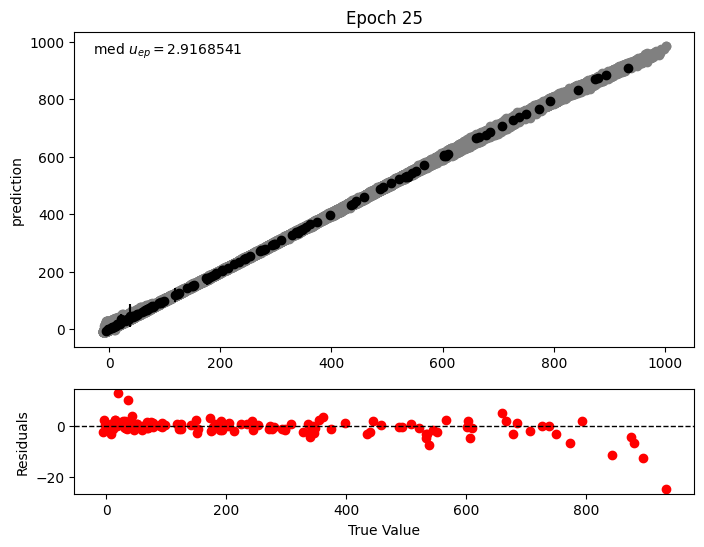

epoch 26 0.26
epoch 27 0.27
epoch 28 0.28
epoch 29 0.29
epoch 30 0.3
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[150.83069   369.6693    108.52822   620.0724    128.36237   472.99005
 265.65524    13.235847    2.6172318 779.7916    614.00745   169.54752
  -4.225211   47.880177  126.9325     48.09289    80.3016     67.95694
  42.868416    6.4945197  12.199666  470.24677   106.810616   51.142067
 124.22142   597.10144    76.32333   467.00308    18.506414  119.75333
 308.97684   328.1419     57.19034   393.47443   668.4713     41.94863
 453.64377   495.3982     -1.9932414 335.96002   695.79675    27.222178
  18.136621   56.68168    79.66712    51.969925  148.86555   377.97235
  31.987879  300.53738    84.09977   281.3819    118.78354    38.43268
 192.36665   212.2952     29.087893   58.98828   173.07874   204.66046
 266.6662     37.954655   28.741081  242.87903   758.84454   302.58572
 269.03278   380.7831    107.27489   468.8671    603.7891    574.20135
  

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

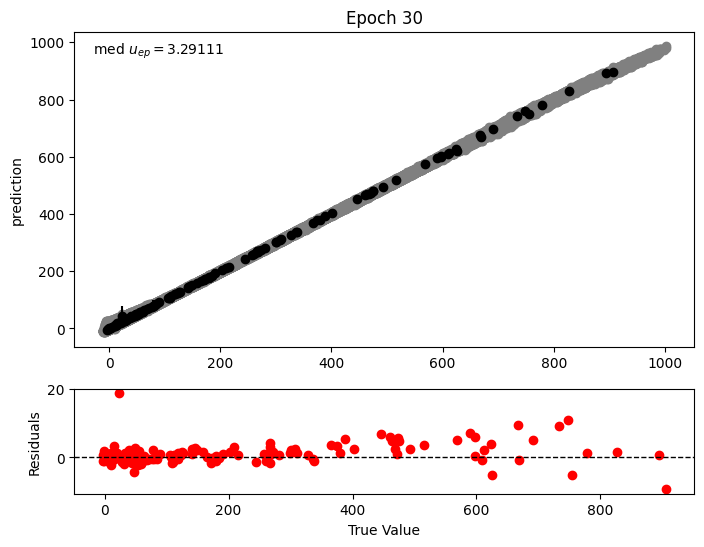

epoch 31 0.31
epoch 32 0.32
epoch 33 0.33
new best loss 2.097806453704834 in epoch 33
epoch 34 0.34
new best loss 2.0590004920959473 in epoch 34
epoch 35 0.35
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 3.70649529e+01  2.44684570e+02  5.02874489e+01  5.68765137e+02
  5.28791161e+01  6.68551208e+02  7.88773499e+02  8.67738056e+00
  1.64831924e+02  8.57784058e+02  9.15909653e+01  4.00191925e+02
 -1.28262907e-01  4.77395660e+02  5.50036964e+01  7.82152176e+01
  1.75357533e+01  4.56457481e+01  7.17311462e+02  1.05430000e+02
  1.45550858e+02  1.29012497e+02  2.32214127e+02  2.40172333e+02
  3.52553589e+02  7.33670654e+01  6.75963440e+02  5.77994812e+02
  2.93137421e+02  2.65223816e+02  1.24142738e+02  2.14013939e+01
  3.73557159e+02  2.14794052e+02  2.52216446e+02  2.23811836e+01
 -3.57636720e-01  8.73861816e+02  1.06829510e+01  1.74453705e+02
  1.00338890e+02  5.22486038e+01  8.00485779e+02  1.41856781e+02
  8.01621323e+01  3.84485664e+01  7.37315750e+01  1

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

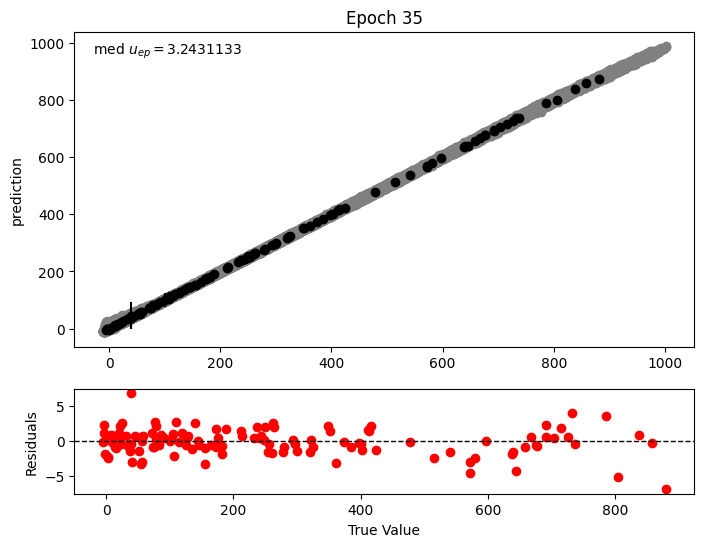

epoch 36 0.36
epoch 37 0.37
epoch 38 0.38
epoch 39 0.39
epoch 40 0.4
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 1.49947624e+01  1.72178207e+02  1.38922443e+01  4.99110718e+01
  9.67865753e+01  6.80191345e+02  6.97629211e+02  7.37592621e+01
  1.69095840e+01  2.40681915e+01  4.92388184e+02  2.36715546e+01
  2.96076927e+01  2.61100037e+02  2.30732605e+02  6.02151123e+02
  8.38807869e+00  1.35832596e+02  2.27143631e+02  9.52591248e+01
  8.50307312e+02  3.72579773e+02  2.71457611e+02 -4.31050110e+00
  1.88973755e+02  1.59400778e+01  2.60841179e+01  8.03771729e+02
  1.38878754e+02  3.38915009e+02  1.05032990e+02  3.96121338e+02
  6.55562286e+01  1.03309692e+02  5.28209567e-01  5.75572021e+02
  1.19868149e+02  2.29573013e+02  3.56613007e+02  4.82191734e+01
  3.46119720e+02  4.45565674e+02  2.14981155e+02  5.59103149e+02
  5.82334518e+00  5.60110901e+02  2.94762268e+01  7.08866272e+01
  6.47249084e+02  2.98648529e+02  4.61990784e+02  5.41346321e+01
  2.6876574

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

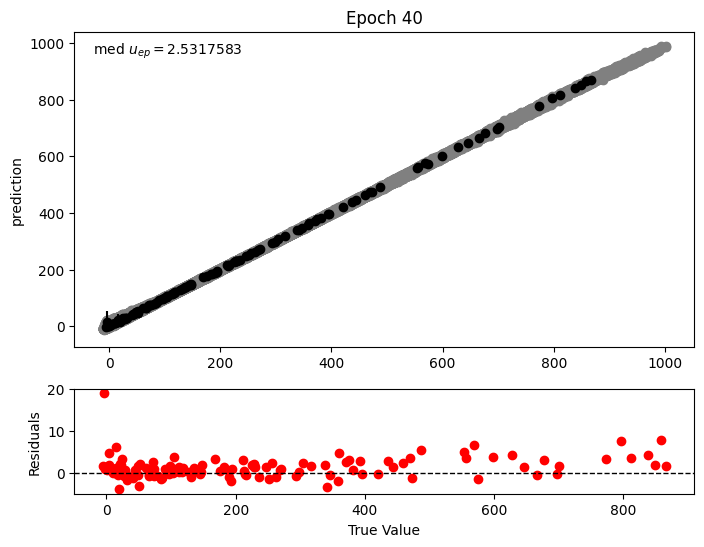

epoch 41 0.41
epoch 42 0.42
new best loss 1.9542040824890137 in epoch 42
epoch 43 0.43
epoch 44 0.44
epoch 45 0.45
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 1.29473953e+02  2.36458099e+02  5.78827881e+02  8.57801086e+02
  8.87378723e+02  1.31977682e+01  2.28872925e+02  1.34389389e+02
  4.14224663e+01  3.66642141e+00  6.97202698e+02  1.74480305e+01
  3.58770111e+02  3.72816110e+00  4.78037292e+02  6.15508957e+01
  1.28717422e+02  3.16659058e+02 -5.50587654e+00  5.50375488e+02
  7.40243607e+01  4.80905518e+02  3.83726807e+02  3.72728180e+02
  7.58677490e+02  2.70380001e+01  8.48386841e+01  3.57985199e+02
  7.76104355e+01  1.79272171e+02 -3.54770660e+00  8.10484192e+02
  1.36014328e+02  2.82919281e+02  1.30192308e+01  4.83587494e+01
  8.69784622e+01  1.51499619e+02  4.66040688e+01  4.76488495e+01
  2.38670769e+01  3.71519562e+02  1.36300552e+02  4.38560944e+02
  2.34499680e+02  1.37580490e+02  2.15073288e+02  7.63703995e+01
  4.94246277e+02  4.19692413e+

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

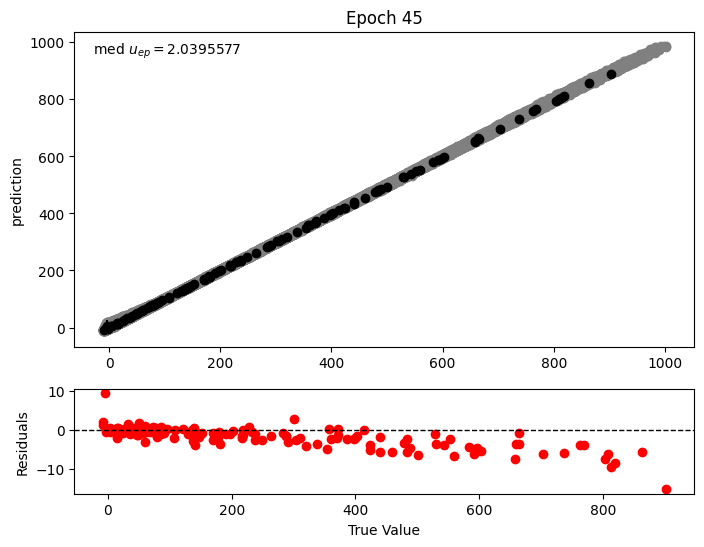

epoch 46 0.46
epoch 47 0.47
epoch 48 0.48
epoch 49 0.49
epoch 50 0.5
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[  5.3604064  51.13573    13.364337  456.518     187.49086   275.1133
  11.561419  820.9985    133.82892   791.8712     67.00572    93.18001
 362.47125   540.3403    612.087      51.58852    28.192974  773.8889
 441.44995    46.71597    65.27786   506.9449     48.8828    101.64793
 173.76172   230.67657    46.49014   318.36252    15.104783  134.04723
  11.122548  136.00749   292.11066   533.22797   237.07494    60.204926
 879.24133   113.47827   388.65408   344.44434   691.2175     95.2633
 752.48956     5.666849   89.4581    402.663      24.371338   24.891771
 382.6598     54.547733   54.537605  149.43248    15.36562   251.68053
  51.169674  768.6564    222.1573    199.40164   264.90854   533.91144
 284.51492    47.605026   64.19306    99.07272   285.06268   570.0348
  25.769108  933.1731    197.84587   103.76891   100.31894    38.25585
  51.8

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

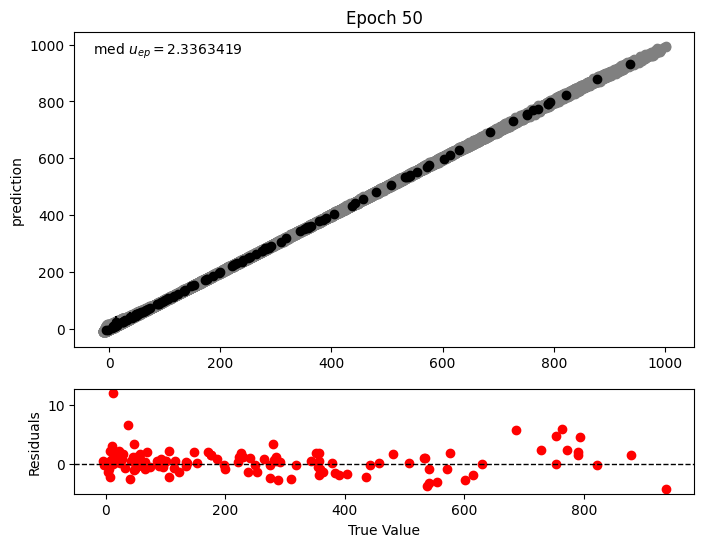

epoch 51 0.51
epoch 52 0.52
new best loss 1.9467253684997559 in epoch 52
epoch 53 0.53
epoch 54 0.54
epoch 55 0.55
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 4.0715603e+01  8.0554962e+02  2.6287415e+01  4.2379279e+02
  3.7491473e+02  3.6981354e+02  2.3532227e+02  2.2722624e+02
  2.4025984e+02  6.2212097e+02  5.5605457e+01  2.2949896e+02
  3.6627768e+02  3.3741158e+01  5.8745628e+01  8.6185066e+01
  2.3156704e+01  1.3155708e+02  8.4560158e+01  3.4310995e+02
  8.1642723e+01  7.6834058e+02  3.1902271e+02  9.0067859e+02
  1.3299971e+02  1.8770542e+01  1.7022653e+02  4.7261264e+02
  4.0571362e+02  4.3691342e+02  3.5164059e+01 -5.7371926e-01
  3.2044519e+02  9.7277771e+01  1.9850418e+02  6.5933105e+01
  1.4849280e+02  4.5222693e+02  7.4827820e+01  5.0940308e+02
  3.2218916e+00  4.0500118e+01  7.9350018e+02  1.3634116e+02
  6.9721710e+02  2.3639338e+01  1.5317436e+02  3.3312500e+02
  8.2891640e+01  1.4970818e+02  1.3036314e+02  6.7247327e+02
  2.9787781e+02  

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

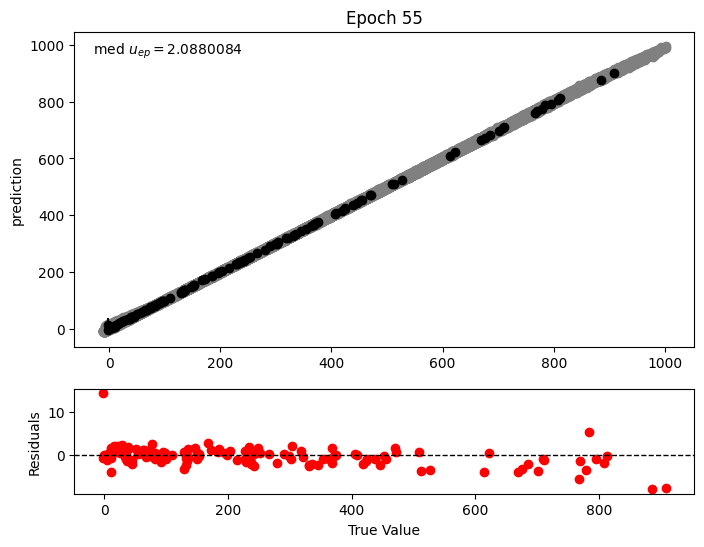

epoch 56 0.56
epoch 57 0.57
new best loss 1.8720861673355103 in epoch 57
epoch 58 0.58
epoch 59 0.59
epoch 60 0.6
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 1.68495621e+02  1.14747124e+02  1.61766373e+02  7.66981995e+02
  4.82337189e+02  5.47434540e+01  1.04750557e+02  7.14630615e+02
  2.03793503e+02  5.08960571e+02  1.84736618e+02  9.79738832e-01
  2.57033295e+02  3.94517273e+02  9.61783791e+00  5.05612762e+02
  7.44566727e+01  1.09104057e+02  5.57990967e+02  1.43240067e+02
  4.91022949e+02  1.50572144e+02  9.67250290e+01  2.05985016e+02
  6.77590576e+02  1.40852676e+02  3.63608185e+02  4.46162689e+02
  1.11523886e+01  3.98268494e+02  5.85084106e+02  1.42972290e+02
  2.20487289e+02  1.30120440e+01  8.82688599e+01  9.81625977e+01
  1.72393219e+02  2.97815247e+02  3.79547615e+01  6.36678734e+01
  4.12639404e+02  7.90252686e+02  2.66798763e+01  1.62231308e+02
  4.01448822e+02  3.45741272e+02  3.64104080e+00  7.49363098e+02
  4.23392120e+02  6.69587631e+0

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

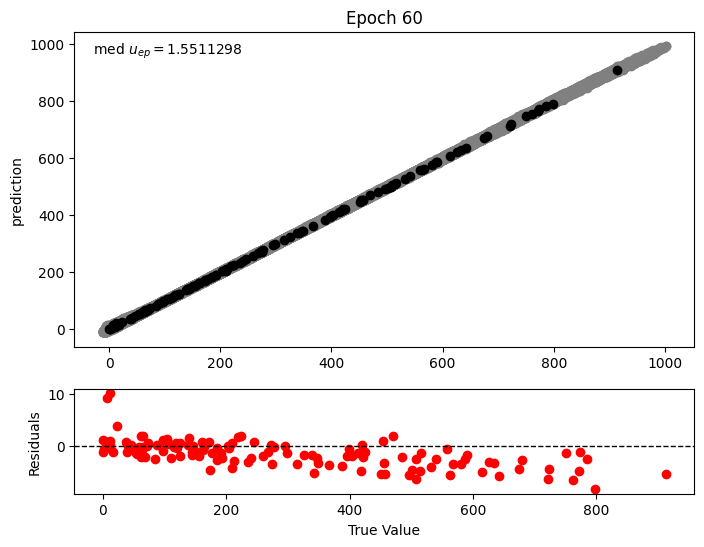

epoch 61 0.61
epoch 62 0.62
epoch 63 0.63
epoch 64 0.64
epoch 65 0.65
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[9.01145477e+01 6.47468750e+02 3.45159973e+02 1.17450203e+02
 9.04330921e+00 1.69593086e+01 8.96588745e+01 1.75833683e+01
 5.19079773e+02 4.40661407e+02 9.69127197e+01 2.94597569e+01
 1.67730293e+01 3.41672913e+02 1.89610901e+02 2.59127472e+02
 8.12428713e-01 5.34295227e+02 2.78060120e+02 1.47147949e+02
 1.21042414e+01 3.98579163e+02 4.50702248e+01 4.08512459e+01
 4.77686249e+02 6.85060730e+02 6.18815369e+02 2.91259125e+02
 1.34788284e+02 3.56304321e+01 4.70182159e+02 5.93135338e+01
 9.29437943e+01 5.28428698e+00 1.22534081e+02 1.96977631e+02
 5.90324463e+02 3.42086792e+02 1.51245224e+02 1.33632568e+02
 2.95290558e+02 1.23647316e+02 6.46333740e+02 9.69563065e+01
 3.17295563e+02 8.89721222e+01 4.64008102e+01 2.90164261e+01
 3.37439392e+02 6.13123360e+01 4.11848145e+02 1.51300720e+02
 4.85664459e+02 2.95587769e+02 1.65303406e+02 3.67138786e+01
 

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

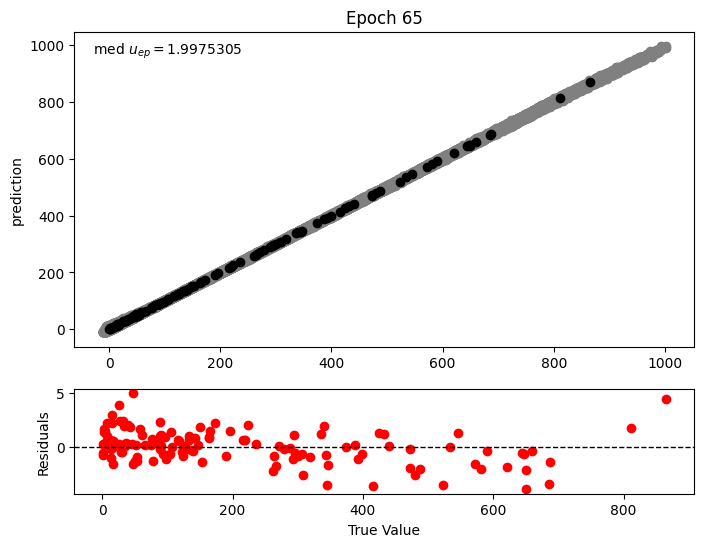

epoch 66 0.66
epoch 67 0.67
epoch 68 0.68
epoch 69 0.69
epoch 70 0.7
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 17.070635  171.12036     5.949215  263.38422    24.291386  305.39224
  91.83362   308.51044   437.47964    40.236435   47.436672  214.52173
  64.6816     78.66646   138.31645   155.24753   123.098526   29.343191
 132.17522    43.949738   62.171455   32.51505   291.22446   156.01672
   4.191998  258.25882   367.5954     41.306286  221.57599   532.5707
 341.98257    41.70902   271.37936   820.2753    446.93756    82.02476
 442.44446     7.2635474  18.189438   77.93815    83.452995  361.5694
  30.566141  204.96655   248.0813    109.71953   298.57028    89.18005
   9.706119   80.61325    16.608986  748.89606    25.013502  360.52826
 349.43237   974.53827   202.04565    11.715768  103.8376    322.58133
 430.93176    56.887535  103.77151   239.03078   167.28674    69.374954
  33.073986  590.3397     17.186783   58.333557   43.14187    91.41804
 178

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

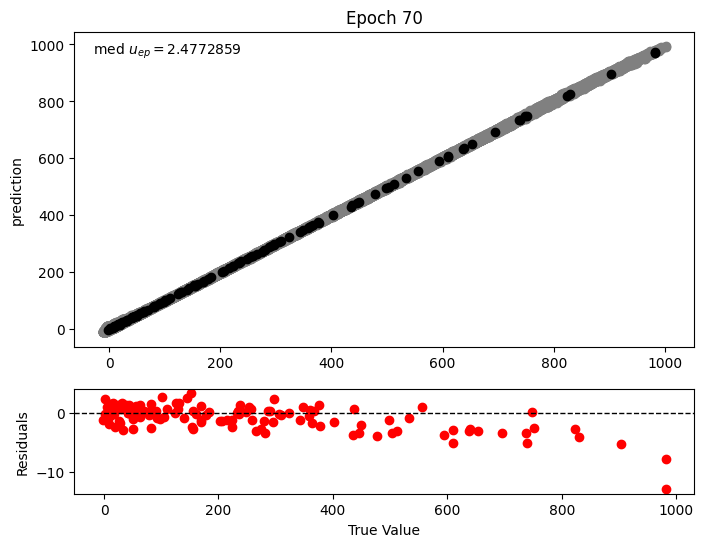

epoch 71 0.71
epoch 72 0.72
epoch 73 0.73
epoch 74 0.74
epoch 75 0.75
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 6.26403259e+02  6.30058594e+02  2.99755707e+02  1.06432312e+02
  8.87084885e+01 -7.10738373e+00  3.71991699e+02  1.67414841e+02
  4.08329041e+02  9.96618195e+01  1.58272476e+02  6.97274094e+01
  4.63411804e+02  6.45960083e+01  2.89291595e+02  1.08583736e+01
  5.35421982e+01  5.66388123e+02 -3.96348149e-01  8.81001740e+01
  1.79860428e+02  1.86703369e+02  4.17733063e+02  5.23808899e+01
  1.06428246e+02  3.87236145e+02  8.21512024e+02  1.59013077e+02
  4.92137726e+02  2.00752365e+02  5.99512451e+02  3.92003601e+02
  2.03823029e+02  2.87733727e+01  9.78421555e+01  1.46596710e+02
  3.77379761e+02  4.91633301e+02  7.66766596e+00  8.74397125e+01
  9.33158203e+02  5.04832428e+02  8.30691101e+02  2.93222321e+02
  3.14194885e+02  2.31517639e+02  9.88495255e+01  9.39523499e+02
  2.66841949e+02  5.42444153e+02  7.28973022e+02  1.51645630e+02
  1.027230

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

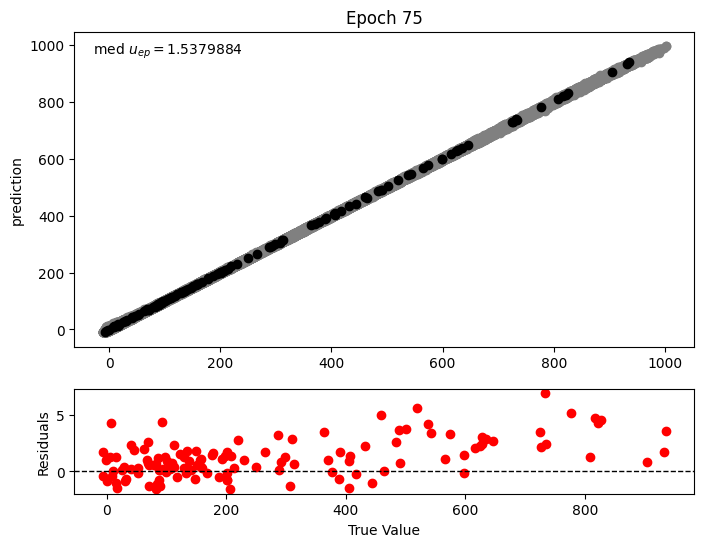

epoch 76 0.76
epoch 77 0.77
epoch 78 0.78
new best loss 1.8458809852600098 in epoch 78
epoch 79 0.79
epoch 80 0.8
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[ 7.3441779e+02  1.8167235e+02  1.4486473e+02  4.0934668e+00
  6.2683551e+02  1.3453224e+02  2.9823911e+02  8.2775122e+02
  3.2552429e+02  4.1932184e+02  8.2185144e+02  1.2082602e+02
  2.0813126e+02  1.8124570e+02  3.3240295e+01  2.6189423e+02
  4.8530022e+01  3.6105736e+01  4.0404999e+02  2.3670926e+02
  4.6030167e+02  6.8931207e+02  4.6359988e+02  1.9617746e+02
  4.5022794e+02  3.8676285e+02  7.5048236e+02  6.1984003e+02
  4.1133859e+02  2.4079147e+02  2.3444551e+02  7.8717201e+01
  4.0909406e+02  4.6081302e+02  2.4363133e+02  9.9147354e+01
  2.0164114e+01  1.0745025e+02  7.8038437e+01  5.4670532e+02
  5.5164142e+02  3.7933557e+02  9.0906849e+00  2.8875323e+02
  5.7952045e+02  1.1767422e+02  4.6517920e+02  2.6438992e+02
  2.2667560e+02  8.3369629e+01  2.9442127e+01  4.9342551e+02
  5.6107251e+02  3

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

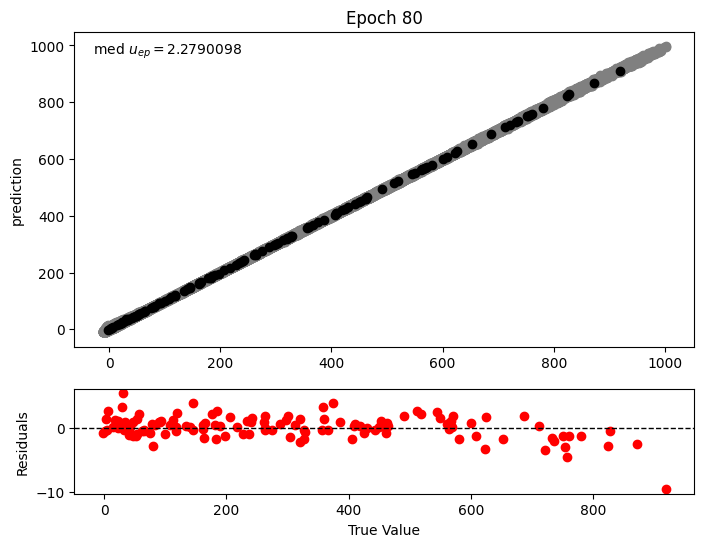

epoch 81 0.81
epoch 82 0.82
epoch 83 0.83
epoch 84 0.84
epoch 85 0.85
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[181.58789   388.26346     6.558299   35.511227  394.9602     31.737425
 941.68744   659.0593    185.0668     55.39199   840.14996   418.0835
 242.11494     9.656385  543.91644   137.38858   114.73901   252.3976
  62.834442  179.07283    88.87049   792.05865    79.18656   144.41463
 335.91037    -4.6619496  54.367218   55.843258   94.94155   288.7641
  49.06757   547.6358      3.3716588  88.283936  246.93617    39.53876
  38.27346    23.959396   90.40868    59.325596   89.9103    198.48097
 163.85234   226.13196   782.6963    531.04126    33.18812    81.06242
 348.87518   192.71906   351.47675   129.1178    533.8033    341.6548
 284.80005     8.631939  130.76033    68.86548   756.89307   536.55756
 510.33694    31.41277    22.467485  250.99777   468.48972   119.60063
  14.028341  560.94507    -1.1917146 199.83324   184.28127    77.66606
 666.2

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

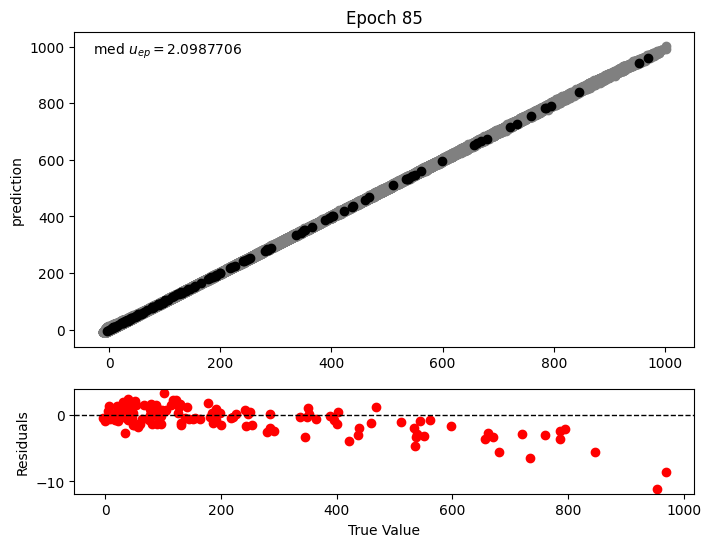

epoch 86 0.86
epoch 87 0.87
epoch 88 0.88
epoch 89 0.89
epoch 90 0.9
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[  6.312206    3.4693985 185.11433   524.5547    123.206696   71.47182
 368.4177    591.21967   157.90898   187.78917    38.912613  359.50348
 214.10501    83.232544  798.954     278.8131    372.6679    479.34818
 125.87458   506.5454    115.00643   136.9949      1.9874003 878.31244
 807.20795   186.39346     4.645566  167.86034    24.294743    5.627304
 318.90216   374.71866    12.079341  367.67786   136.14186   334.66998
 703.08655    52.400864  101.89814   403.61273   187.91086   203.9097
 236.2295    338.56024   101.200195  224.69196   128.11324   608.8704
 172.26527   120.617355  783.47296   131.97931   168.0789    244.26007
 467.23166   715.6566      7.5591354 478.79892   470.1403    622.8156
 228.78026   301.50955   151.5629    777.17413    56.834328   49.24993
 147.61008   446.4717     79.18793   336.99136   568.7947    320.72028
 109.2

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

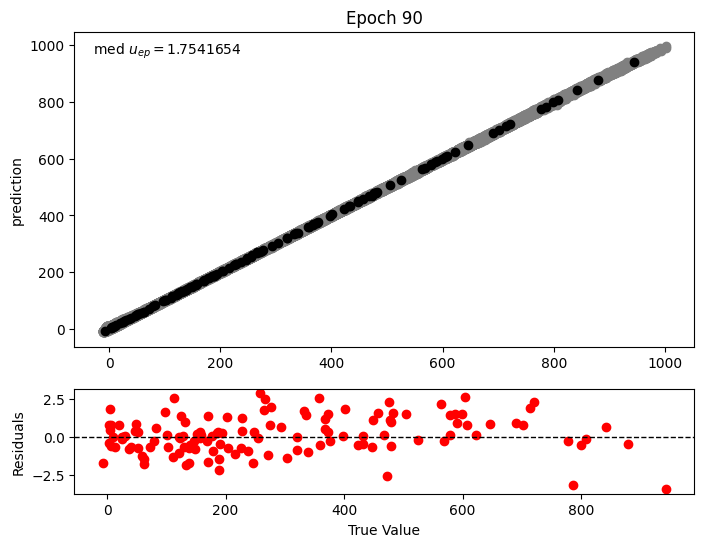

epoch 91 0.91
epoch 92 0.92
epoch 93 0.93
epoch 94 0.94
epoch 95 0.95
types <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shapes (128,) (128,)
[220.2242    253.48555   402.045     896.9933    133.93639   623.8128
  99.63924    98.84267   263.73727    24.044199  505.64062   135.67987
 341.0415    617.96826   202.28587   361.63397   133.46216   792.39923
  52.03787   116.087135  313.94632   222.39235   390.06668    85.44171
 544.9739    198.52733     2.565137  300.35168   268.0446    155.07346
 304.04358   264.91418   103.67348   518.34485   166.51466    69.855064
 318.05008    18.635014  259.91165   184.50877    72.99754    62.970318
  74.906586  341.65958    69.517204   67.924576   26.918575  547.064
  68.27947    89.123     229.97517   364.60202   190.73463   194.63719
 154.59767   182.94073    65.644615   62.23998    60.77364   156.25476
  43.800964   46.62459    71.51293    59.27732   185.22368   288.82428
  72.558655  841.259     159.73763   192.3324    216.01164   146.41406
   9

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

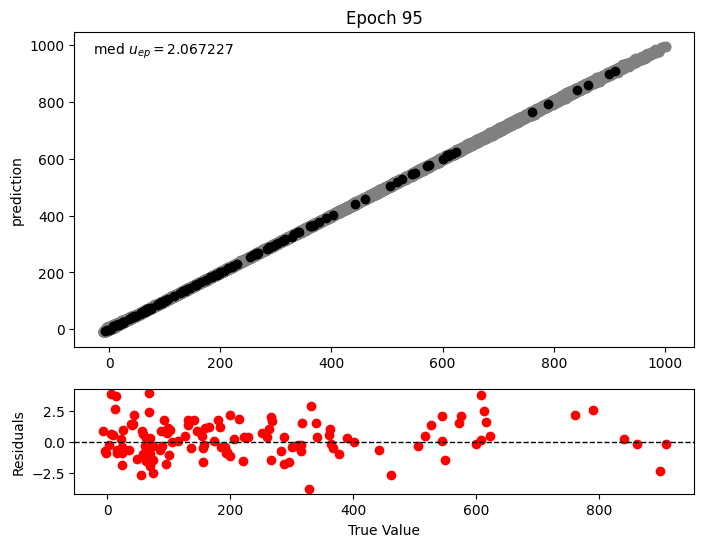

epoch 96 0.96
new best loss 1.819514274597168 in epoch 96
epoch 97 0.97
new best loss 1.790823221206665 in epoch 97
epoch 98 0.98
epoch 99 0.99
start at 1708973954.688662 end at 1708974070.961118
116.27245593070984


<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

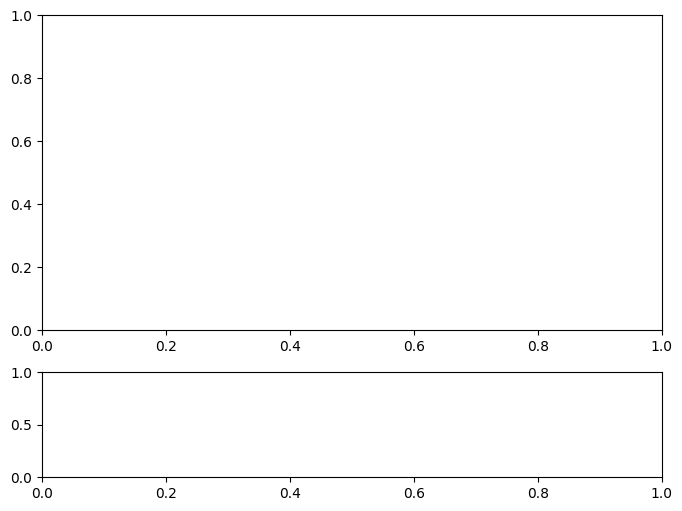

In [18]:
# my own training model
INIT_LR = LR
model_ensemble = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_TYPE,
             model_name,
             EPOCHS=n_epochs,
             save_checkpoints=False,
             path_to_model='../models/',
             plot=True)
 

In [ ]:
# run 100 and see how many fail
# my own training model
n_models = 100
mse_list = []
for i in range(n_models):
    print('model', i)
    INIT_LR = LR
    model_ensemble, final_mse = train.train_DER(trainDataLoader,
                 x_val,
                 y_val,
                 INIT_LR,
                 DEVICE,
                 COEFF,
                 DER_TYPE,
                 model_name,
                 EPOCHS=n_epochs,
                 save_checkpoints=False,
                 path_to_model='../models/',
                 plot=False,
                 verbose=False)
    mse_list.append(final_mse)

In [ ]:
print(range(n_models))
print(mse_list)
plt.clf()
plt.scatter(range(n_models), mse_list)
plt.ylabel('MSE')
plt.xlabel('n_models')
plt.show() 

In [ ]:
# save the mse list
np.save('MSE_DER_100_epochs.npy', mse_list)

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [ ]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model = model_ensemble
model.eval()
# first, normalize the x value using the xmin and xmax before
if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    # I think I'm doing the un-normalization wrong for the other terms in the output:
    aleatoric_OG = np.sqrt((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) - 1))
    aleatoric_mod = np.sqrt(((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) * (1 + (y_norm_pred[:,1] * (outputmax - outputmin) + outputmin))) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) * (y_norm_pred[:,1]* (outputmax - outputmin) + outputmin)))
    epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])
else:
    y_pred_all_terms = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = y_pred_all_terms[:,0]
    aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
    aleatoric_mod = np.sqrt((y_pred_all_terms[:,3]  * (1 + y_pred_all_terms[:,1] )) / (y_pred_all_terms[:,2] * y_pred_all_terms[:,1]))
    epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_pred_all_terms[:,1])

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = r'$u_{al}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax1.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax1.set_title('Aleatoric Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = aleatoric_mod,
             label = r'$u_{al}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax2.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax2.set_title('Aleatoric Error Meinert+2022')
plt.show()

### Now epistemic

In [ ]:
print, epistemic_OG, epistemic_mod 

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = epistemic_OG,
             label = r'$u_{ep}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax1.set_title('Epistemic Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = epistemic_mod,
             label = r'$u_{ep}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax2.set_title('Epistemic Error Meinert+2022')
plt.show()
